# <div style='background:#2b6684;color:white;padding:0.5em;border-radius:0.2em'>Домашнее задание №1</div>

### <div style='background:#119063;color:white;padding:0.5em;border-radius:0.2em'>Import Libs</div>

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
from collections import defaultdict
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

from blackjack_double import BlackjackDoubleEnv
from blackjack_double_second import BlackjackDoubleCountingEnv

## <div style='background:#119063;color:white;padding:0.5em;border-radius:0.2em'>Часть первая, с блекджеком и стратегиями</div>

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:

- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
    - hit  — взять ещё одну карту;
    - stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).


1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [4]:
from func_19_20_21 import play_game, evaluate_pi

In [5]:
env = gym.make('Blackjack-v1')
env.natural = True

In [6]:
type(env)

gym.wrappers.order_enforcing.OrderEnforcing

In [7]:
num_experiments = int(input())
print(f'Кол-во раздач: {num_experiments}')

500000
Кол-во раздач: 500000


In [8]:
reward_mean = evaluate_pi(env, n=num_experiments)
print(f'Оценка выигрыша при стратегии "19-20-21": {reward_mean:.5f}')

Оценка выигрыша при стратегии "19-20-21": -0.19820


2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [9]:
from q_learn import q_learning, get_pi_by_Q, plot_q_learinig

In [10]:
A = (0, 1)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]

Q = np.zeros((len(S), len(A)))
Q = q_learning(env, A, Q, episodes=100_000, alpha=0.02, epsilon=0.1)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=num_experiments)
print(f'Оценка выигрыша при стратегии, обученной с помощью Q-обучения: {reward_mean:.5f}')

Оценка выигрыша при стратегии, обученной с помощью Q-обучения: -0.14535


**Попробуем подобрать параметры alpha и epsilon.**   
Перебирать все - это очень долго, поэтому буду подбирать epsilon при фиксированном alpha и наоборот.  
И так прогнать 2-3 итераций. Должно сойтись.

In [12]:
%%time
for epsilon in np.linspace(0.05, 1, 20):
    tries = 10
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = q_learning(env, A, Q, episodes=100_000, alpha=0.00005, epsilon=epsilon)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi)
    print(f'epsilon={epsilon:.5f}, reward={(reward / tries):.5f}')

epsilon=0.05000, reward=-0.07616
epsilon=0.10000, reward=-0.07782
epsilon=0.15000, reward=-0.07427
epsilon=0.20000, reward=-0.07341
epsilon=0.25000, reward=-0.07643
epsilon=0.30000, reward=-0.06613
epsilon=0.35000, reward=-0.06632
epsilon=0.40000, reward=-0.06291
epsilon=0.45000, reward=-0.06531
epsilon=0.50000, reward=-0.06173
epsilon=0.55000, reward=-0.06542
epsilon=0.60000, reward=-0.05978
epsilon=0.65000, reward=-0.05809
epsilon=0.70000, reward=-0.05647
epsilon=0.75000, reward=-0.05397
epsilon=0.80000, reward=-0.04997
epsilon=0.85000, reward=-0.05231
epsilon=0.90000, reward=-0.05151
epsilon=0.95000, reward=-0.04735
epsilon=1.00000, reward=-0.04937
CPU times: user 43min 36s, sys: 28.1 s, total: 44min 4s
Wall time: 43min 36s


In [13]:
for alpha in [0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05]: #np.linspace(0.001, 0.02, 20):
    tries = 10
    reward = 0
    for i in range(tries):
        Q = np.zeros((len(S), len(A)))
        Q = q_learning(env, A, Q, episodes=100_000, alpha=alpha, epsilon=0.95)
        pi = get_pi_by_Q(Q)
        reward += evaluate_pi(env, pi)
    print(f'alpha={alpha:.5f}, reward={(reward / tries):.5f}')

alpha=0.00001, reward=-0.05185
alpha=0.00002, reward=-0.05109
alpha=0.00005, reward=-0.04866
alpha=0.00010, reward=-0.04806
alpha=0.00020, reward=-0.04982
alpha=0.00050, reward=-0.05370
alpha=0.00100, reward=-0.05250
alpha=0.00200, reward=-0.07357
alpha=0.00500, reward=-0.10490
alpha=0.01000, reward=-0.14908
alpha=0.02000, reward=-0.15796
alpha=0.05000, reward=-0.12552


Cлучайное блуждание при обучении хуже, чем следование стратегии, что очевидно

In [14]:
Q = np.zeros((len(S), len(A)))
Q = q_learning(env, A, Q, episodes=100_000, alpha=0.0001, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=num_experiments)
print(f'Оценка выигрыша при стратегии, обученной с помощью Q-обучения: {reward_mean:.5f}')

Оценка выигрыша при стратегии, обученной с помощью Q-обучения: -0.05079


3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Награда каждого эпизода усреднена по 50 экспериментам и посчитана на 100 раздачах. Всего 1000 эпизодов


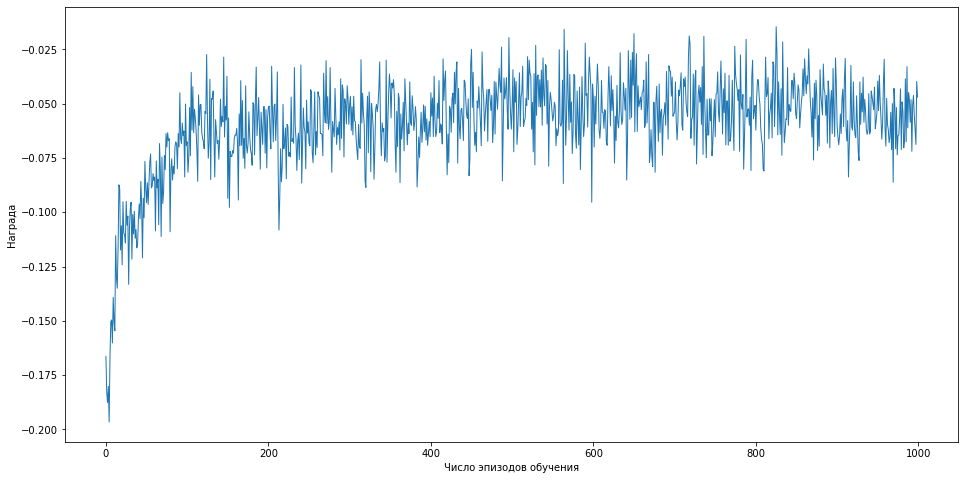

CPU times: user 5min 1s, sys: 1.8 s, total: 5min 3s
Wall time: 5min 2s


In [22]:
%%time
# A = (0, 1)
plot_q_learinig(env, A, alpha=0.00005, epsilon=0.95)

## <div style='background:#119063;color:white;padding:0.5em;border-radius:0.2em'>Часть вторая, удвоенная</div>

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
- Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [23]:
env = BlackjackDoubleEnv(natural=True)
A = (0, 1, 2)

S = list(itertools.product(range(4, 32), range(1, 11), (True, False)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

In [25]:
Q = np.zeros((len(S), len(A)))
Q = q_learning(env, A, Q, episodes=100_000, alpha=0.00005, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi)

print(f'Оценка выигрыша в варианте с double при стратегии, обученной с помощью Q-обучения: {reward_mean:.5f}')

Оценка выигрыша в варианте с double при стратегии, обученной с помощью Q-обучения: -0.02913


Награда каждого эпизода усреднена по 50 экспериментам и посчитана на 100 раздачах. Всего 1000 эпизодов


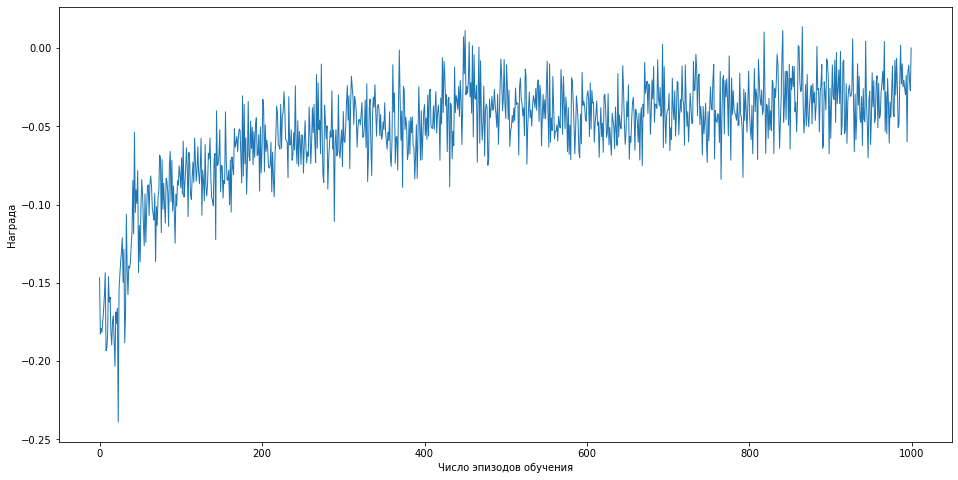

In [27]:
plot_q_learinig(env, A, alpha=0.0002, epsilon=0.95)

## <div style='background:#119063;color:white;padding:0.5em;border-radius:0.2em'>Часть третья, в главной роли — Дастин Хоффман</div>


А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.
- Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.



----------------------

In [52]:
env = BlackjackDoubleCountingEnv(natural=True)
A = (0, 1, 2)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False), range(-44, 45)))
S = [s for s in S if not s[2] or (s[2] and 12 <= s[0] <= 21)]
s2idx = {state: i for i, state in enumerate(S)}

Состояний получается в 89 раз больше. Попробуем взять хотя бы в 5 раз больше эпизодов для обучения

In [53]:
from func_part_three import q_learning_double, evaluate_pi, get_pi_by_Q, plot_q_learinig_double

In [43]:
Q = np.zeros((len(S), len(A)))
Q = q_learning_double(env, A, Q, episodes=500_000, alpha=0.0002, epsilon=0.95)
pi = get_pi_by_Q(Q)
reward_mean = evaluate_pi(env, pi, n=500_000)

print(f'Оценка выигрыша в варианте с double и подсчетом карт при стратегии, обученной с помощью Q-обучения : {reward_mean:.5f}')

Оценка выигрыша в варианте с double и подсчетом карт при стратегии, обученной с помощью Q-обучения : 0.01819


Награда каждого эпизода усреднена по 50 экспериментам и посчитана на 100 раздачах. Всего 1000 эпизодов


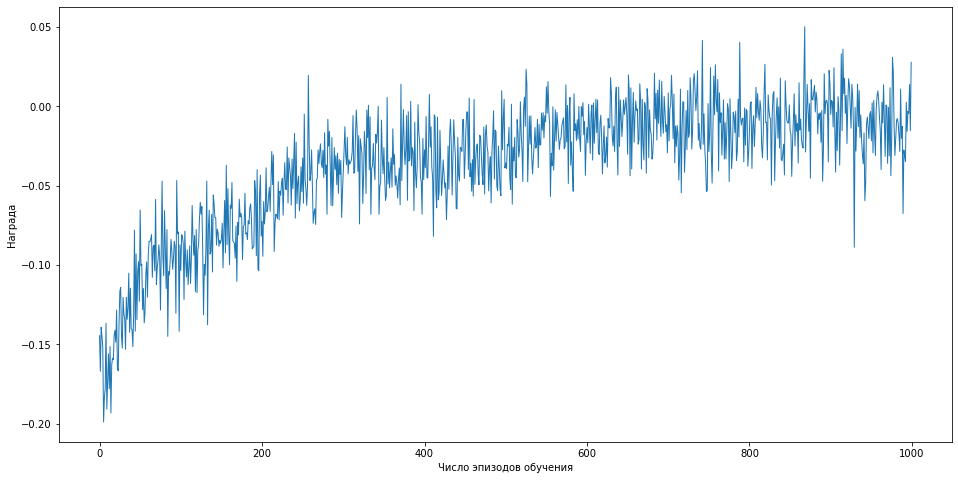

In [54]:
plot_q_learinig_double(env, A, alpha=0.00002, epsilon=1)